In [1]:
import argparse
import logging
import os
import sys

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

import utils.help as help
from eval import eval_net
from unet import UNet
from unet import TiedUNet

from torch.utils.tensorboard import SummaryWriter
from utils.dataset import BrainD
from torch.utils.data import DataLoader, random_split

from dice_loss import dice_coeff
from dice_loss import one_hot

from train import train_net 
from train import get_args

from matplotlib import pyplot as plt

In [2]:
dir_img = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/vols/'
dir_mask = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/asegs/'
dir_checkpoint_1 = 'checkpoints_1/'
dir_checkpoint_2 = 'checkpoints_2/'

np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(threshold=10_000)

In [3]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
args = get_args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

INFO: Using device cuda


In [4]:
target_label_numbers = [0,2,3,4,10,16,17,28,31,41,42,43,49,53,63]
val_percent = 0.1
batch_size = args.batchsize
lr = args.lr
img_scale = args.scale

dataset = BrainD(dir_img, dir_mask, label_numbers=target_label_numbers)
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - 2 * n_val
n_test = n_val
train, val, test = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val, batch_size=8, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')

INFO: Creating dataset with 7329 examples


In [5]:
one_example = next(iter(train_loader))

image = one_example['image'][0]
mask = one_example['mask'][0]

print(image.shape)
print(mask.shape)

sq_img = image.squeeze(0).squeeze(0)
sq_msk = mask.squeeze(0).squeeze(0)

torch.Size([1, 160, 192])
torch.Size([1, 160, 192])


torch.Size([160, 192])


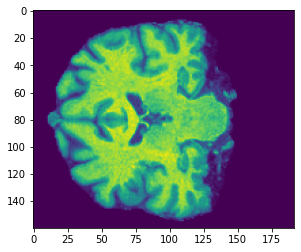

In [6]:
print(sq_img.shape)
plt.imshow(sq_img)

torch.Size([160, 192])


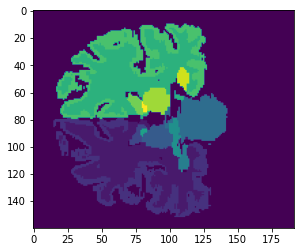

In [7]:
print(sq_msk.shape)
plt.imshow(sq_msk)

In [ ]:
net2 = TiedUNet(n_channels=1, n_classes=15, bilinear=True)

logging.info(f'Network:\n'
             f'\t{net2.n_channels} input channels\n'
             f'\t{net2.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if net2.bilinear else "Transposed conv"} upscaling')

net2.to(device=device)
train_scores2, val_scores2, train_var_2, val_var_2 = train_net(net=net2,
                                                                epochs=args.epochs,
                                                                batch_size=args.batchsize,
                                                                lr=args.lr,
                                                                device=device,
                                                                img_scale=args.scale,
                                                                val_percent=args.val / 100,
                                                                checkpoint=2,
                                                                target_label_numbers=target_label_numbers,
                                                                dataset=dataset,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                writer=writer)

INFO: Network:
	1 input channels
	15 output channels (classes)
	Bilinear upscaling
INFO: Starting training:
        Epochs:          1
        Batch size:      8
        Learning rate:   0.001
        Training size:   6597
        Validation size: 732
        Checkpoints:     True
        Device:          cuda
        Images scaling:  1
    
Validation round:  99%|█████████▊| 361/366 [00:04<00:00, 82.65batch/s]
                                                                      INFO: Validation Dice Loss: 0.27434538207093223
Validation round:  98%|█████████▊| 357/366 [00:04<00:00, 91.92batch/s]
                                                                      INFO: Validation Dice Loss: 0.26363737327479275
Validation round:  66%|██████▋   | 243/366 [00:03<00:01, 88.07batch/s]


Validation round: 100%|█████████▉| 365/366 [00:04<00:00, 91.05batch/s]
                                                                      INFO: Validation Dice Loss: 0.25694213547016104
Validation round:  99%|█████████▊| 361/366 [00:04<00:00, 95.94batch/s]
                                                                      INFO: Validation Dice Loss: 0.2755896060681734
Validation round:  99%|█████████▉| 362/366 [00:04<00:00, 85.51batch/s]
                                                                      INFO: Validation Dice Loss: 0.2667205556819999
Validation round:  38%|███▊      | 139/366 [00:02<00:03, 71.68batch/s]


Validation round:  98%|█████████▊| 357/366 [00:04<00:00, 90.01batch/s]
                                                                      INFO: Validation Dice Loss: 0.2642194561131014
Validation round:  99%|█████████▉| 364/366 [00:04<00:00, 87.42batch/s]
                                                                      INFO: Validation Dice Loss: 0.26319240872325794
Validation round:  98%|█████████▊| 358/366 [00:04<00:00, 89.59batch/s]
                                                                      INFO: Validation Dice Loss: 0.26329083219577704
Validation round:  17%|█▋        | 64/366 [00:01<00:20, 15.09batch/s]


Validation round:  98%|█████████▊| 358/366 [00:04<00:00, 93.15batch/s]
                                                                      INFO: Validation Dice Loss: 0.26171790169236436
Validation round:  99%|█████████▉| 363/366 [00:04<00:00, 91.67batch/s]
                                                                      INFO: Validation Dice Loss: 0.26366253571757853
Validation round: 100%|█████████▉| 365/366 [00:04<00:00, 92.30batch/s]
                                                                      INFO: Validation Dice Loss: 0.26384552938690603


Validation round: 100%|█████████▉| 365/366 [00:04<00:00, 88.53batch/s]
                                                                      INFO: Validation Dice Loss: 0.2637973066236152
Validation round:  99%|█████████▊| 361/366 [00:04<00:00, 84.60batch/s]
                                                                      INFO: Validation Dice Loss: 0.2641301659938416
Validation round:  71%|███████   | 259/366 [00:03<00:01, 90.14batch/s]


Validation round:  99%|█████████▉| 362/366 [00:04<00:00, 95.25batch/s]
                                                                      INFO: Validation Dice Loss: 0.26420602096560225
Validation round:  97%|█████████▋| 356/366 [00:04<00:00, 85.00batch/s]
                                                                      INFO: Validation Dice Loss: 0.2639988467015855
Validation round:  99%|█████████▉| 364/366 [00:04<00:00, 91.03batch/s]
                                                                      INFO: Validation Dice Loss: 0.26385684954664096
Validation round:  46%|████▌     | 169/366 [00:02<00:02, 83.75batch/s]


Validation round:  99%|█████████▉| 362/366 [00:04<00:00, 87.01batch/s]
                                                                      INFO: Validation Dice Loss: 0.26432988462878054
Validation round:  99%|█████████▉| 364/366 [00:04<00:00, 91.70batch/s]
                                                                      INFO: Validation Dice Loss: 0.2641856896747005
Validation round:  99%|█████████▉| 363/366 [00:04<00:00, 90.92batch/s]
                                                                      INFO: Validation Dice Loss: 0.2638179856897052
Validation round:  18%|█▊        | 65/366 [00:01<00:22, 13.29batch/s]


Validation round: 100%|██████████| 366/366 [00:04<00:00, 91.93batch/s]
                                                                      INFO: Validation Dice Loss: 0.2636636756156963
Validation round:  99%|█████████▉| 362/366 [00:04<00:00, 88.97batch/s]
                                                                      INFO: Validation Dice Loss: 0.2642402049622249
Validation round:  98%|█████████▊| 357/366 [00:04<00:00, 84.29batch/s]
                                                                      INFO: Validation Dice Loss: 0.26422725471316794


Validation round:  98%|█████████▊| 357/366 [00:04<00:00, 88.80batch/s]
                                                                      INFO: Validation Dice Loss: 0.26404255050453335
Epoch 1/1:  66%|██████▌   | 4366/6597 [02:54<00:31, 71.36img/s, loss (batch)=0.13]  

In [8]:
net1 = UNet(n_channels=1, n_classes=15, bilinear=True)

logging.info(f'Network:\n'
             f'\t{net1.n_channels} input channels\n'
             f'\t{net1.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if net1.bilinear else "Transposed conv"} upscaling')

net1.to(device=device)
train_scores1, val_scores1, train_var_1, val_var_1 = train_net(net=net1,
                                                                epochs=args.epochs,
                                                                batch_size=args.batchsize,
                                                                lr=args.lr,
                                                                device=device,
                                                                img_scale=args.scale,
                                                                val_percent=args.val / 100,
                                                                checkpoint=1,
                                                                target_label_numbers=target_label_numbers,
                                                                dataset=dataset,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                writer=writer)

INFO: Network:
	1 input channels
	15 output channels (classes)
	Bilinear upscaling
INFO: Starting training:
        Epochs:          1
        Batch size:      8
        Learning rate:   0.001
        Training size:   6597
        Validation size: 732
        Checkpoints:     True
        Device:          cuda
        Images scaling:  1
    
Validation round:  98%|█████████▊| 89/91 [00:13<00:00,  8.18batch/s]
                                                                    INFO: Validation Dice Loss: 0.060606623007045994
Validation round: 100%|██████████| 91/91 [00:04<00:00, 25.76batch/s]
                                                                    INFO: Validation Dice Loss: 0.05498595412943389
Validation round: 100%|██████████| 91/91 [00:04<00:00, 25.10batch/s]
                                                                    INFO: Validation Dice Loss: 0.05684054135293751
Validation round:   0%|          | 0/91 [00:00<?, ?batch/s]


Validation round: 100%|██████████| 91/91 [00:04<00:00, 23.22batch/s]
                                                                    INFO: Validation Dice Loss: 0.05521854193328501
Validation round:  99%|█████████▉| 90/91 [00:03<00:00, 27.62batch/s]
                                                                    INFO: Validation Dice Loss: 0.04913145139977172
Validation round: 100%|██████████| 91/91 [00:04<00:00, 22.94batch/s]
                                                                    INFO: Validation Dice Loss: 0.04742289129849318
Validation round:  27%|██▋       | 25/91 [00:01<00:04, 13.35batch/s]


Validation round: 100%|██████████| 91/91 [00:04<00:00, 24.09batch/s]
                                                                    INFO: Validation Dice Loss: 0.051301189012579865
Validation round: 100%|██████████| 91/91 [00:04<00:00, 27.48batch/s]
                                                                    INFO: Validation Dice Loss: 0.04353753632896549
Epoch 1/1:  89%|████████▉ | 5865/6597 [03:02<00:22, 32.16img/s, loss (batch)=0.0971]
INFO: Checkpoint 1 saved !


configuring plot one


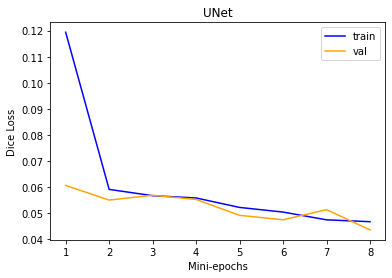

In [10]:
print("configuring plot one")
domain = len(train_scores1)
x_values = [i+1 for i in range(domain)]
plt.title("UNet")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores1, color="blue", label="train")
plt.plot(x_values, val_scores1, color="orange", label="val")
plt.legend()
plt.show()
plt.close()

configuring plot two


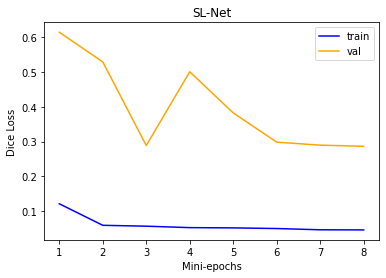

In [11]:
print("configuring plot two")
domain = len(train_scores2)
x_values = [i+1 for i in range(domain)]
plt.title("SL-Net")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores2, color="blue", label="train")
plt.plot(x_values, val_scores2, color="orange", label="val")
plt.legend()
plt.show()
plt.close()

In [16]:
import math

# Create another simulation dataset for test
train_loader = DataLoader(train, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
val_loader = DataLoader(val, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
test_loader = DataLoader(test, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

# Get the first batch
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))
test_batch = next(iter(test_loader))

inputs_train = train_batch['image']
labels_train = train_batch['mask']

inputs_val = val_batch['image']
labels_val = val_batch['mask']

inputs_test = test_batch['image']
labels_test = test_batch['mask']

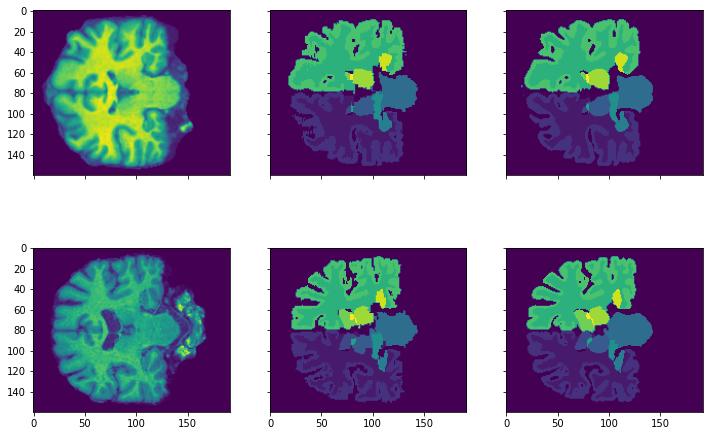

In [17]:
net1.eval() 
inputs = inputs_train.to(device=device, dtype=torch.float32)
labels = labels_train.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

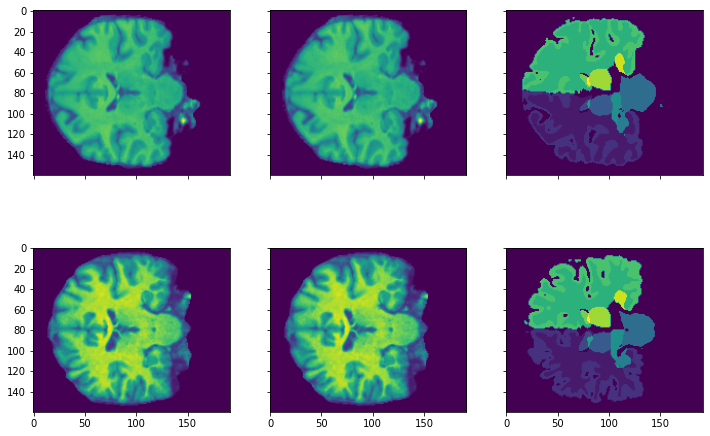

In [18]:
net1.eval() 
inputs = inputs_val.to(device=device, dtype=torch.float32)
labels = inputs_val.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

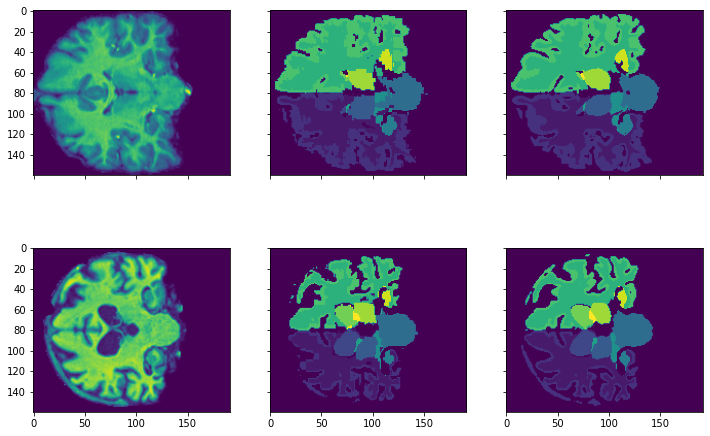

In [19]:
net1.eval() 
inputs = inputs_test.to(device=device, dtype=torch.float32)
labels = labels_test.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

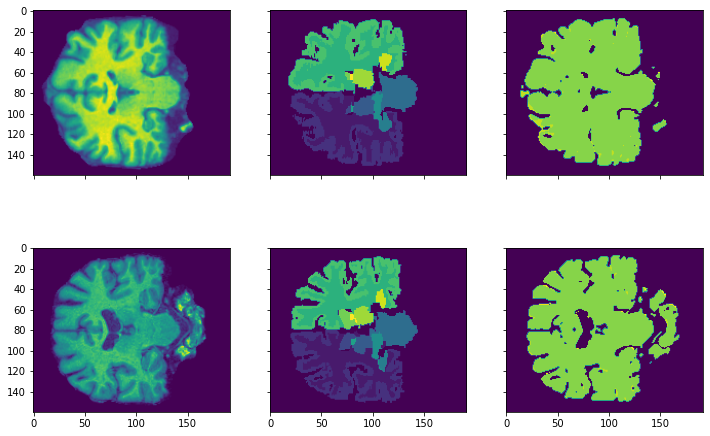

In [20]:
net2.eval()
inputs = inputs_train.to(device=device, dtype=torch.float32)
labels = labels_train.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

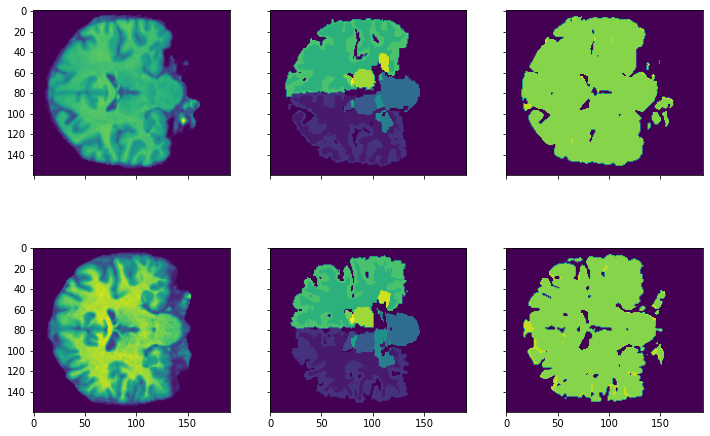

In [21]:
net2.eval()
inputs = inputs_val.to(device=device, dtype=torch.float32)
labels = labels_val.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

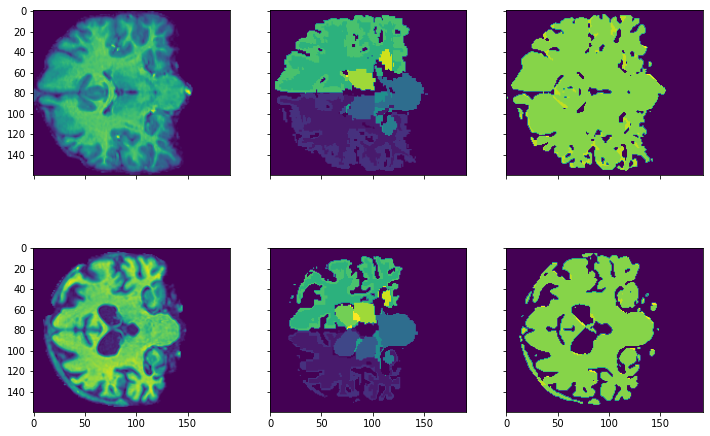

In [14]:
net2.eval()
inputs = inputs_test.to(device=device, dtype=torch.float32)
labels = labels_test.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

help.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])